In [6]:
from contextlib import closing
import io
import numpy
from copy import deepcopy

from matplotlib import pyplot
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (
    Activation,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    InputLayer,
    MaxPooling2D,
)
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist


In [7]:
# ---------- Prepare data section ---------- #
# load mnist dataset
# x_train, y_train - training dataset and validation vector
# x_test, y_test - validation dataset and validation vector
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# make a deep copy to render data
render_x = deepcopy(x_train)
render_y = deepcopy(y_train)

# declare num of training samples
num_labels = len(numpy.unique(y_train))

# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size

# convert a single list to categorical list of lists
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

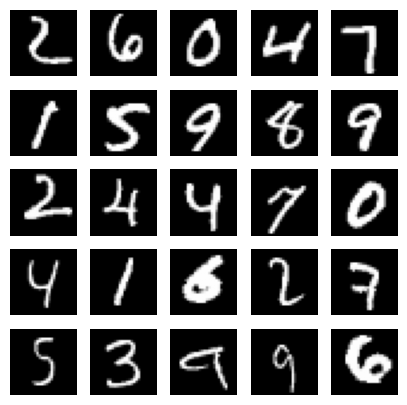

In [8]:
# ----------- Show sample section ---------- #
indexes = numpy.random.randint(0, render_x.shape[0], size=25)
images = render_x[indexes]
labels = render_y[indexes]
# plot the 25 mnist digits
pyplot.figure(figsize=(5,5))
for i in range(len(indexes)):
    pyplot.subplot(5, 5, i + 1)
    image = images[i]
    pyplot.imshow(image, cmap='gray')
    pyplot.axis('off')
pyplot.savefig('samples.png')
pyplot.show()
pyplot.close('all')

In [9]:
# network parameters
BATCH_SIZE = 32
HIDDEN_UNITS = 128
DROPOUT = 0.2
KERNEL_SIZE = 3
POOL_SIZE = 2
FILTERS = 64
LAYER_FILTERS = [32, 64]
EPOCHS = 20
LATENT_DIM = 16
input_shape = (image_size, image_size, 1)

def build_model(units=HIDDEN_UNITS, dropout=DROPOUT, input_size=input_size, batch_size=BATCH_SIZE,
                num_labels=num_labels, kernel_size=KERNEL_SIZE, pool_size=POOL_SIZE, latent_dim=LATENT_DIM,
                filters=FILTERS, layer_filters=LAYER_FILTERS):

    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    # stack of Conv2D(32)-Conv2D(64)
    for filters in layer_filters:
        x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
        shape = K.int_shape(x)
        # generate latent vector
        x = Flatten()(x)
        latent = Dense(latent_dim, name='latent_vector')(x)
    # instantiate encoder model
    encoder = Model(inputs, latent, name='encoder')
    encoder.summary()
    plot_model(encoder, to_file='encoder.png', show_shapes=True)
    return model


model = build_model()

# # close file handler at the end of context execution
# with closing(io.StringIO()) as fh:
#     model.summary(print_fn=lambda x: fh.write(x + "\n"))
#     summary_str = fh.getvalue()

# # set up image representation
# pyplot.figure(figsize=(12, 6))
# pyplot.text(0, 1, summary_str, fontsize=12, family='monospace', va='top')
# pyplot.axis('off')
# # save as PNG
# pyplot.savefig('model-summary.png', bbox_inches='tight')
# pyplot.close()

ValueError: Input 0 of layer "conv2d_2" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 6272)

In [5]:
# model = load_model('model.keras')

In [6]:
# loss function for one-hot vector
# use of adam optimizer
# accuracy is good metric for classification tasks
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
# validate the model on test dataset to determine generalization
_, acc = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=0)
model.save('model.keras')

In [7]:
pyplot.plot(history.history['accuracy'], label='accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.ylim([0.5, 1])
pyplot.legend(loc='lower right')
pyplot.savefig("accuracy-history.png")
pyplot.show()
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Final model accuracy: {test_acc*100:.3f}%", )